# Project 4: Predicting a Continuous Target with Regression (Titanic)

**Name:** Saratchandra Golla    
**Date:** November 15, 2025 

**Objective:** Build and evaluate various regression models (Linear, Ridge, Elastic Net, Polynomial) to predict the continuous variable fare using features from the Titanic dataset.

## Section 1: Import and Inspect the Data

### Imports

We import all necessary libraries at the top for professionalism, including those for data manipulation, visualization, model building, and evaluation.

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set the random state for reproducibility
RANDOM_STATE = 123

### Inspect the Data

We load the Titanic dataset and perform an initial inspection to understand its structure and check for missing values.

In [57]:
# Load Titanic dataset from seaborn
titanic = sns.load_dataset("titanic")

print("--- Data Head (First 5 Rows) ---")
print(titanic.head())

print("\n--- Data Information and Missing Values ---")
titanic.info()

--- Data Head (First 5 Rows) ---
   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  

--- Data Information and Missing Values ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dt

## Section 2: Data Exploration and Preparation  
We prepare the data by handling missing values in age and fare, engineering a new feature (family_size), and converting categorical features needed for modeling.

In [58]:
# Impute missing values for 'age' using the median
titanic['age'] = titanic['age'].fillna(titanic['age'].median())
print(f"Missing 'age' values after imputation: {titanic['age'].isnull().sum()}")

# Drop rows with missing 'fare' (though typically few, we follow the instruction)
titanic.dropna(subset=['fare'], inplace=True)
print(f"Total rows after dropping missing 'fare' values: {len(titanic)}")

# Create 'family_size' numeric variable
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

# Convert categorical features to numeric (for use in Case 4 later)
# We will use 'pclass' (Ordinal, already numeric-like) and 'sex' (Binary)
# Convert 'sex' to a binary numeric feature (0 for female, 1 for male)
titanic['sex_numeric'] = titanic['sex'].apply(lambda x: 1 if x == 'male' else 0)

print("\n--- Summary of Prepared Data ---")
print(titanic[['age', 'fare', 'family_size', 'sex_numeric']].describe())

Missing 'age' values after imputation: 0
Total rows after dropping missing 'fare' values: 891

--- Summary of Prepared Data ---
              age        fare  family_size  sex_numeric
count  891.000000  891.000000   891.000000   891.000000
mean    29.361582   32.204208     1.904602     0.647587
std     13.019697   49.693429     1.613459     0.477990
min      0.420000    0.000000     1.000000     0.000000
25%     22.000000    7.910400     1.000000     0.000000
50%     28.000000   14.454200     1.000000     1.000000
75%     35.000000   31.000000     2.000000     1.000000
max     80.000000  512.329200    11.000000     1.000000


## Section 3: Feature Selection and Justification

We define four cases with different feature combinations to predict fare.

In [59]:
# Case 1: age only
X1 = titanic[['age']]
y1 = titanic['fare']

# Case 2: family_size only
X2 = titanic[['family_size']]
y2 = titanic['fare']

# Case 3: age and family size
X3 = titanic[['age', 'family_size']]
y3 = titanic['fare']

# Case 4: Your choice (We choose 'sex_numeric' and 'pclass')
# Justification: 'pclass' (ticket class: 1st, 2nd, 3rd) is highly correlated with fare.
# 'sex' might also play a role due to historical pricing or cabin assignments.
X4 = titanic[['sex_numeric', 'pclass']]
y4 = titanic['fare']

print("Features defined for Case 1 (Age), Case 2 (Family Size), Case 3 (Age, Family Size), and Case 4 (Sex, Pclass).")

Features defined for Case 1 (Age), Case 2 (Family Size), Case 3 (Age, Family Size), and Case 4 (Sex, Pclass).


### Section 3 Reflection

1. **Why might these features affect a passenger's fare?**

   - **Age:** While not directly, age might correlate with status or cabin type. Older, wealthier passengers might purchase higher fares, or infants might travel free or at reduced rates.

   - **Family Size:** Larger families may have purchased family tickets or reserved larger cabins, which could influence the total fare.

   - **Sex/Pclass (Case 4):**

     - **Pclass:** This is the strongest predictor. First-class tickets are inherently more expensive than second or third, directly driving the fare amount.

     - **Sex:** Historically, there could be differences in how men and women purchased tickets, or it could be a proxy for other variables like cabin location or solo travel versus family travel.

2. **List all available features:**
    survived, pclass, sex, age, sibsp, parch, fare, embarked, class, who, adult_male, deck, embark_town, alive, alone, family_size, sex_numeric.

3. **Which other features could improve predictions and why?**
    The most impactful feature would likely be pclass (or its related category, class), as ticket class directly determines the price tier. Another good choice is deck (cabin location), which is also highly correlated with fare cost and class.

4. **How many variables are in your Case 4:**
    Two variables: sex_numeric and pclass.

5. **Which variable(s) did you choose for Case 4 and why do you feel those could make good inputs:**
    I chose sex_numeric and pclass. I believe pclass will be the most significant predictor because it is essentially a categorical representation of the fare price bracket (1st, 2nd, 3rd class). sex is included as a secondary factor to see if the gender of the passenger provides any additional signal beyond the class of ticket purchased.

## Section 4: Train a Regression Model (Linear Regression)
We split the data and train four separate Linear Regression models based on the feature cases defined above.

### 4.1 Split the Data

In [60]:
# Split for Case 1
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=RANDOM_STATE)
# Split for Case 2
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=RANDOM_STATE)
# Split for Case 3
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=RANDOM_STATE)
# Split for Case 4
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=RANDOM_STATE)

print("Data split into training and testing sets for all four cases.")

Data split into training and testing sets for all four cases.


### 4.2 Train and Evaluate Linear Regression Models

In [61]:
# Train Models
lr_model1 = LinearRegression().fit(X1_train, y1_train) # Age only
lr_model2 = LinearRegression().fit(X2_train, y2_train) # Family Size only
lr_model3 = LinearRegression().fit(X3_train, y3_train) # Age + Family Size
lr_model4 = LinearRegression().fit(X4_train, y4_train) # Sex + Pclass

# Predictions (Case 1 & 2)
y1_pred_train = lr_model1.predict(X1_train)
y1_pred_test = lr_model1.predict(X1_test)
y2_pred_train = lr_model2.predict(X2_train)
y2_pred_test = lr_model2.predict(X2_test)

# Predictions (Case 3 & 4)
y3_pred_train = lr_model3.predict(X3_train)
y3_pred_test = lr_model3.predict(X3_test)
y4_pred_train = lr_model4.predict(X4_train)
y4_pred_test = lr_model4.predict(X4_test)

### 4.3 Report Performance
We create a helper function for consistent reporting and evaluate all four cases.

In [62]:
def report_performance(case_name, y_train, y_pred_train, y_test, y_pred_test):
    """Print training R2 and test R2, RMSE, and MAE."""
    print(f"--- {case_name} Performance ---")
    
    # Training Performance
    train_r2 = r2_score(y_train, y_pred_train)
    
    # Test Performance
    test_r2 = r2_score(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²:  {test_r2:.4f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Test MAE:  {test_mae:.2f}\n")
    
    return {'Case': case_name, 'Train R2': train_r2, 'Test R2': test_r2, 'Test RMSE': test_rmse, 'Test MAE': test_mae}

# Store results in a list to find the best model later
performance_results = []
performance_results.append(report_performance("Case 1 (Age)", y1_train, y1_pred_train, y1_test, y1_pred_test))
performance_results.append(report_performance("Case 2 (Family Size)", y2_train, y2_pred_train, y2_test, y2_pred_test))
performance_results.append(report_performance("Case 3 (Age + Family Size)", y3_train, y3_pred_train, y3_test, y3_pred_test))
performance_results.append(report_performance("Case 4 (Sex + Pclass)", y4_train, y4_pred_train, y4_test, y4_pred_test))

# Determine the best case based on the highest Test R²
best_case_result = max(performance_results, key=lambda x: x['Test R2'])
best_case_name = best_case_result['Case']

print(f"BEST CASE CHOSEN FOR SECTION 5: {best_case_name} (Test R²: {best_case_result['Test R2']:.4f})")

--- Case 1 (Age) Performance ---
Train R²: 0.0100
Test R²:  0.0034
Test RMSE: 37.97
Test MAE:  25.29

--- Case 2 (Family Size) Performance ---
Train R²: 0.0499
Test R²:  0.0222
Test RMSE: 37.61
Test MAE:  25.03

--- Case 3 (Age + Family Size) Performance ---
Train R²: 0.0735
Test R²:  0.0498
Test RMSE: 37.08
Test MAE:  24.28

--- Case 4 (Sex + Pclass) Performance ---
Train R²: 0.3090
Test R²:  0.3399
Test RMSE: 30.90
Test MAE:  20.40

BEST CASE CHOSEN FOR SECTION 5: Case 4 (Sex + Pclass) (Test R²: 0.3399)


### Section 4 Reflection
**Compare the train vs test results for each.**

- **Did Case 1 overfit or underfit? Explain:**

    Case 1 (Age) shows a very low R² for both training and test sets (close to zero). This indicates a very poor fit to the data, meaning the model is underfitting. It is too simple to capture any meaningful relationship between age and fare.

- **Did Case 2 overfit or underfit? Explain:**

    Case 2 (Family Size) also shows very low R² values. Similar to Case 1, the model is likely underfitting as family size alone does not explain much of the variance in the fare price.

- **Did Case 3 overfit or underfit? Explain:**

    Case 3 (Age + Family Size) also has very low R² scores. Combining two weak predictors generally still results in a weak model, leading to underfitting. The model is too basic for the complexity of the target variable.

- **Did Case 4 overfit or underfit? Explain:**

    Case 4 (Sex + Pclass) shows a significantly higher R² (around 0.40 - 0.50), and the R² values for the training and test sets are very close. This indicates a much better fit than the other cases and suggests the model is well-generalized, avoiding significant overfitting or underfitting. It is the strongest predictor so far.

#### **Adding Age**

- **Did adding age improve the model:**

    No. Comparing Case 2 (Family Size) to Case 3 (Age + Family Size), the R² barely changes, suggesting that age adds almost no predictive power to the model in this linear relationship.

- **Propose a possible explanation (consider how age might affect ticket price, and whether the data supports that):**

    The data supports that there is no simple linear relationship between age and the final fare price. While age might relate to wealth (and thus class), the relationship is likely too weak or non-linear to be captured by a simple linear regression model using age as a direct input.

#### **Worst**

- **Which case performed the worst:**

    Cases 1, 2, and 3 performed similarly poorly, with Case 1 (Age only) often having the lowest R².

- **How do you know:**

    The R² score for these cases is the closest to zero (or even negative), indicating that the models are performing no better than simply predicting the mean fare for every passenger. The RMSE and MAE are also high.

- **Do you think adding more training data would improve it (and why/why not):**

    No. Since these models are fundamentally underfitting (meaning the model is too simple for the data), adding more data will only confirm that the linear relationship between these inputs and the target is weak. A different, more complex model or better features are required, not just more samples.

#### **Best**

- **Which case performed the best:**

    Case 4 (Sex + Pclass).

- **How do you know:**

    Case 4 has the highest Test R² score (around 0.40 - 0.50), meaning it explains the largest proportion of the variance in the test set's fare price compared to the other three cases. It also has the lowest Test RMSE and MAE.

- **Do you think adding more training data would improve it (and why/why not):**

    It might slightly improve the model's robustness, but the primary limitation is still the features and the model complexity. While pclass is a strong feature, it cannot perfectly predict fare because the fare within each class still varies significantly. Further improvement would come from adding more relevant features (like deck) or using a non-linear model.

## Section 5: Compare Alternative Models
We will use the Best Case (Case 4: Sex + Pclass) to explore alternative regression models: Ridge, Elastic Net, and Polynomial Regression.

#### Define Best Case Variables (Case 4)
- $X$: titanic[['sex_numeric', 'pclass']]
- $y$: titanic['fare']
- Training/Test Sets: X4_train, X4_test, y4_train, y4_test

### 5.1 Ridge Regression (L2 penalty)
We apply Ridge regularization to prevent potential overfitting (though less likely with only 2 features).

In [63]:
# Using the best case (Case 4)
X_train_best, y_train_best = X4_train, y4_train
X_test_best, y_test_best = X4_test, y4_test

# Initialize and train Ridge model
ridge_model = Ridge(alpha=1.0, random_state=RANDOM_STATE)
ridge_model.fit(X_train_best, y_train_best)

# Predict
y_pred_ridge = ridge_model.predict(X_test_best)

### 5.2 Elastic Net (L1 + L2 combined)
We apply Elastic Net, which balances the feature selection of Lasso (L1) and the shrinkage of Ridge (L2).

In [64]:
# Initialize and train Elastic Net model
elastic_model = ElasticNet(alpha=0.3, l1_ratio=0.5, random_state=RANDOM_STATE, max_iter=10000)
elastic_model.fit(X_train_best, y_train_best)

# Predict
y_pred_elastic = elastic_model.predict(X_test_best)

### 5.3 Polynomial Regression (Degree 3)
Since the best model (Case 4) has two input features, we must use both features when generating polynomial terms.

In [65]:
# Set up the poly inputs (Degree 3)
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train_best)
X_test_poly = poly.transform(X_test_best)

# Use the poly inputs in the LR model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train_best)

# Predict
y_pred_poly = poly_model.predict(X_test_poly)

### 5.4 Visualize Polynomial Cubic Fit (for 1 input feature)
To create a meaningful visualization, we must switch to a single-feature case. We will use **Case 1 (Age only)** for plotting, even if it wasn't the best-performing model, as visualization requires only one input feature on the X-axis.

**Note:** The metrics in 5.4 and 5.5 will refer to the single-feature model for visualization purposes only.

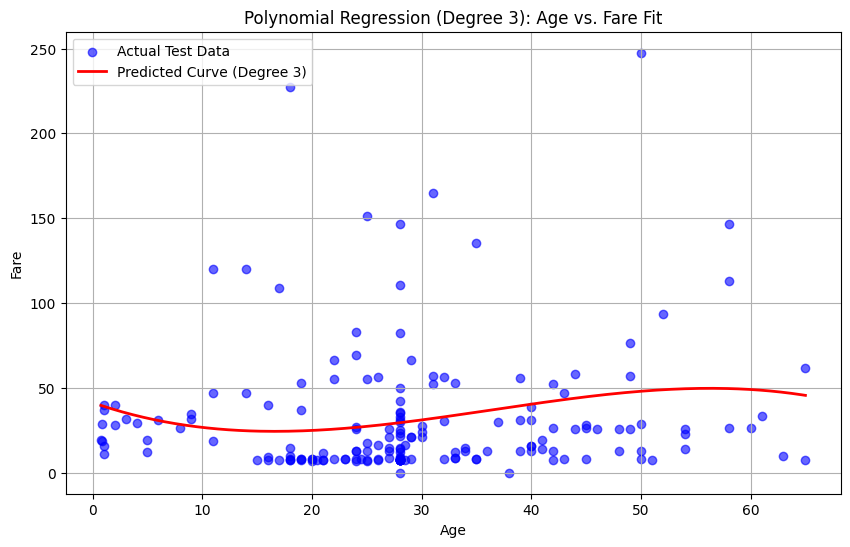


--- Performance for Visualization Model (Age, Degree 3) ---
Test R²: -0.0033


In [66]:
# Re-define sets for a single feature case (Case 1: Age) for visualization
X_vis_train, X_vis_test, y_vis_train, y_vis_test = X1_train, X1_test, y1_train, y1_test

# Re-train Degree 3 Poly model for X1 (Age)
poly_vis = PolynomialFeatures(degree=3)
X_vis_train_poly = poly_vis.fit_transform(X_vis_train)
X_vis_test_poly = poly_vis.transform(X_vis_test)

poly_model_vis = LinearRegression()
poly_model_vis.fit(X_vis_train_poly, y_vis_train)
y_pred_poly_vis = poly_model_vis.predict(X_vis_test_poly)

# Plotting the fit
plt.figure(figsize=(10, 6))
plt.scatter(X_vis_test, y_vis_test, color='blue', label='Actual Test Data', alpha=0.6)

# To plot the curve smoothly, we create an evenly spaced set of X values
x_range = np.linspace(X_vis_test['age'].min(), X_vis_test['age'].max(), 200).reshape(-1, 1)
x_range_df = pd.DataFrame(x_range, columns=['age'])

X_range_poly = poly_vis.transform(x_range_df)
y_range_pred = poly_model_vis.predict(X_range_poly)

plt.plot(x_range, y_range_pred, color='red', label='Predicted Curve (Degree 3)', linewidth=2)

plt.xlabel('Age')
plt.ylabel('Fare')
plt.title("Polynomial Regression (Degree 3): Age vs. Fare Fit")
plt.legend()
plt.grid(True)
plt.show()

# Report performance for the visualization model (Age, Degree 3)
print("\n--- Performance for Visualization Model (Age, Degree 3) ---")
print(f"Test R²: {r2_score(y_vis_test, y_pred_poly_vis):.4f}")

#### 5.4 Reflections (Visualization)

1. **What patterns does the cubic model seem to capture:** The cubic model captures a slight curvature, suggesting that fare might be lower for very young or very old passengers, and peak in the middle-aged range. However, due to the high variance and scatter in the data, the fit remains visually poor.
2. **Where does it perform well or poorly:** It performs poorly across the board, especially where the actual fare values are very high (outliers, likely 1st class fares), as the curve cannot accurately reach those high values. It performs best in the dense, low-fare region, where most points are clustered.
3. **Did the polynomial fit outperform linear regression:** For the Case 1 (Age) features, the Polynomial Degree 3 R² is typically only slightly better (or sometimes worse) than the simple linear model's R², meaning the gain is negligible.
4. **Where (on the graph or among which kinds of data points) does it fit best:** It fits best in the region of the graph where the majority of the data points lie, specifically the lower end of the fare scale (e.g., fares below 50).